***Storing the data in a SQL database***

In [53]:
# import necessary libraries
import sqlite3
import pandas as pd

In [2]:
# Read in previously created CSVs that contain my three data source datasets
top_games = pd.read_csv('top_games.csv') 
google_games = pd.read_csv('google_games.csv') 
game_deals = pd.read_csv('game_deals.csv') 

In [8]:
# An Unnamed column showed up in all my csv's, not sure why.
google_games.head()

,Unnamed: 0,google rating,game,google num reviews,google num installs,google price,content rating,genres
0,1653,4.5,roblox,4447388,100000000,0.0,everyone 10+,adventure;action & adventure
1,1654,4.5,subway surfers,27722264,1000000000,0.0,everyone 10+,arcade
2,1655,4.4,candy crush saga,22426677,500000000,0.0,everyone,casual
3,1656,4.7,solitaire,254258,10000000,0.0,everyone,card
4,1657,4.5,bubble shooter,148897,10000000,0.0,everyone,casual


In [9]:
# Remove the Unnamed columns
top_games = top_games.drop(columns=['Unnamed: 0'])
google_games = google_games.drop(columns=['Unnamed: 0'])
game_deals = game_deals.drop(columns=['Unnamed: 0'])

In [14]:
# Create the database that I want to store my tables in
conn = sqlite3.connect('games.db')
c = conn.cursor()

In [15]:
# Create a table for the top 50 game data
c.execute('CREATE TABLE top_games (game, top_ranking, worldwide_revenue, release_date, publisher, genres)')
conn.commit()

In [16]:
# Create a table for the google playstore game data
c.execute('CREATE TABLE google_games (google_rating, game, google_num_reviews, google_num_installs, google_price, content_rating, genres)')
conn.commit()

In [17]:
# Create a table for the game sale data
c.execute('CREATE TABLE game_deals (game, cheapshark_id, sale_price, reg_price, percent_savings, critic_score, rating_disposition, steam_rating, steam_num_reviews, deal_rating)')
conn.commit()

In [18]:
# Load the pandas dataframe data into the corresponding SQL tables
top_games.to_sql('top_games', conn, if_exists='replace', index = False)
google_games.to_sql('google_games', conn, if_exists='replace', index = False)
game_deals.to_sql('game_deals', conn, if_exists='replace', index = False)

C:\Users\myraw\anaconda3\lib\site-packages\pandas\core\generic.py:2653: UserWarning: The spaces in these column names will not be changed. In pandas versions < 0.14, spaces were converted to underscores.
  sql.to_sql(


In [19]:
# Close the database after inserting tables and data
conn.close()

In [20]:
# Create a query for each of the tables in sqlite3, just to make sure that they were loaded correctly
with sqlite3.connect("games.db") as conn:
    cursor = conn.cursor()
    rows = cursor.execute('SELECT * FROM top_games LIMIT 5')
    for row in rows:
        print(row)

(1, 'monster strike', 8239000000, 'august 8, 2013', 'mixi', 'physics / rpg / puzzle')
(2, 'honor of kings / arena of valor', 7810200000, 'november 26, 2015', 'tencent games', 'moba')
(3, 'puzzle & dragons', 7712000000, 'february 20, 2012', 'gungho online entertainment', 'puzzle / rpg')
(4, 'clash of clans', 7000000000, 'august 2, 2012', 'supercell (tencent)', 'strategy')
(5, 'candy crush saga', 5410000000, 'november 14, 2012', 'king (activision blizzard)', 'puzzle')


In [21]:
with sqlite3.connect("games.db") as conn:
    cursor = conn.cursor()
    rows = cursor.execute('SELECT * FROM google_games LIMIT 5')
    for row in rows:
        print(row)

(4.5, 'roblox', 4447388, 100000000, 0.0, 'everyone 10+', 'adventure;action & adventure')
(4.5, 'subway surfers', 27722264, 1000000000, 0.0, 'everyone 10+', 'arcade')
(4.4, 'candy crush saga', 22426677, 500000000, 0.0, 'everyone', 'casual')
(4.7, 'solitaire', 254258, 10000000, 0.0, 'everyone', 'card')
(4.5, 'bubble shooter', 148897, 10000000, 0.0, 'everyone', 'casual')


In [22]:
with sqlite3.connect("games.db") as conn:
    cursor = conn.cursor()
    rows = cursor.execute('SELECT * FROM game_deals LIMIT 5')
    for row in rows:
        print(row)

('naruto to boruto shinobi striker - deluxe edition', 189692, 11.99, 79.98, 85, 0, 'none', 0, 0, 10.0)
("ni no kuni ii: revenant kingdom - the prince's edition", 171780, 11.99, 79.98, 85, 0, 'none', 0, 0, 10.0)
('project cars 2 - deluxe edition', 170776, 13.49, 89.99, 85, 0, 'none', 0, 0, 10.0)
('dragon ball fighter z  fighterz edition', 174472, 14.24, 94.98, 85, 0, 'none', 0, 0, 10.0)
('dragon ball fighter z  ultimate edition', 174473, 16.49, 109.97, 85, 0, 'none', 0, 0, 10.0)


***Merging the Data***

In [23]:
# Use python to take the data from the three tables and join them into one dataset.
with sqlite3.connect("games.db") as conn:
    cursor = conn.cursor()
    cursor.execute('''SELECT * 
                      FROM top_games
                      FULL OUTER JOIN google_games
                          ON top_games.game = google_games.game
                      FULL OUTER JOIN game_deals
                          ON top_games.game = game_deals.game;''')
    df = pd.DataFrame(cursor.fetchall())
    df.columns = [x[0] for x in cursor.description]

OperationalError: RIGHT and FULL OUTER JOINs are not currently supported

In [25]:
# Apparently, SQLite only has INNER and LEFT JOIN, but you can get around this using UNION ALL
with sqlite3.connect("games.db") as conn:
    cursor = conn.cursor()
    cursor.execute('''SELECT *
                      FROM top_games
                      LEFT JOIN google_games
                          ON top_games.game = google_games.game
                      UNION ALL
                      SELECT *
                      FROM google_games
                      LEFT JOIN top_games
                          ON top_games.game = google_games.game
                      SELECT * 
                      FROM top_games
                      LEFT JOIN game_deals
                          ON top_games.game = game_deals.game
                      UNION ALL
                      SELECT *
                      FROM game_deals
                      LEFT JOIN top_games
                          ON top_games.game = game_deals.game;''')
    df = pd.DataFrame(cursor.fetchall())
    df.columns = [x[0] for x in cursor.description]

OperationalError: near "SELECT": syntax error

In [38]:
# I really wanted to join the tables in my SQL query and then save it as a dataframe, but I have to do an outer join 
# because I know there is data overlapping between all three tables, so now I guess I'll just pull each table out of 
# the database separately and save it as a pandas dataframe.
con = sqlite3.connect("games.db")
df1 = pd.read_sql_query("SELECT * FROM top_games", con)
df2 = pd.read_sql_query("SELECT * FROM google_games", con)
df3 = pd.read_sql_query("SELECT * FROM game_deals", con)
con.close()

In [39]:
df1.head()

,top ranking,game,worldwide revenue,release date,publisher,genres
0,1,monster strike,8239000000,"august 8, 2013",mixi,physics / rpg / puzzle
1,2,honor of kings / arena of valor,7810200000,"november 26, 2015",tencent games,moba
2,3,puzzle & dragons,7712000000,"february 20, 2012",gungho online entertainment,puzzle / rpg
3,4,clash of clans,7000000000,"august 2, 2012",supercell (tencent),strategy
4,5,candy crush saga,5410000000,"november 14, 2012",king (activision blizzard),puzzle


In [40]:
df2.head()

,google rating,game,google num reviews,google num installs,google price,content rating,genres
0,4.5,roblox,4447388,100000000,0.0,everyone 10+,adventure;action & adventure
1,4.5,subway surfers,27722264,1000000000,0.0,everyone 10+,arcade
2,4.4,candy crush saga,22426677,500000000,0.0,everyone,casual
3,4.7,solitaire,254258,10000000,0.0,everyone,card
4,4.5,bubble shooter,148897,10000000,0.0,everyone,casual


In [41]:
df3.head()

,game,cheapshark id,sale price,reg price,percent savings,critic score,rating disposition,steam rating,steam num reviews,deal rating
0,naruto to boruto shinobi striker - deluxe edition,189692,11.99,79.98,85,0,none,0,0,10.0
1,ni no kuni ii: revenant kingdom - the prince's...,171780,11.99,79.98,85,0,none,0,0,10.0
2,project cars 2 - deluxe edition,170776,13.49,89.99,85,0,none,0,0,10.0
3,dragon ball fighter z fighterz edition,174472,14.24,94.98,85,0,none,0,0,10.0
4,dragon ball fighter z ultimate edition,174473,16.49,109.97,85,0,none,0,0,10.0


In [43]:
# Now I will use python to join my 3 dataframes
final_df = df1.merge(df2,on='game', how='outer').merge(df3,on='game', how='outer')

In [46]:
final_df.head()

,top ranking,game,worldwide revenue,release date,publisher,genres_x,google rating,google num reviews,google num installs,google price,...,genres_y,cheapshark id,sale price,reg price,percent savings,critic score,rating disposition,steam rating,steam num reviews,deal rating
0,1.0,monster strike,8.239000e+09,"august 8, 2013",mixi,physics / rpg / puzzle,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2.0,honor of kings / arena of valor,7.810200e+09,"november 26, 2015",tencent games,moba,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,3.0,puzzle & dragons,7.712000e+09,"february 20, 2012",gungho online entertainment,puzzle / rpg,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,4.0,clash of clans,7.000000e+09,"august 2, 2012",supercell (tencent),strategy,4.6,44891723.0,100000000.0,0.0,...,strategy,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,5.0,candy crush saga,5.410000e+09,"november 14, 2012",king (activision blizzard),puzzle,4.4,22426677.0,500000000.0,0.0,...,casual,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [71]:
# Since I know my third df doesn't have any overlap because they are PC games vs mobile games, I just want to see how 
# much overlap there was with my first two dfs by doing an inner join. 
inner_df = df1.merge(df2,on='game')
inner_df

,top ranking,game,worldwide revenue,release date,publisher,genres_x,google rating,google num reviews,google num installs,google price,content rating,genres_y
0,4,clash of clans,7000000000,"august 2, 2012",supercell (tencent),strategy,4.6,44891723,100000000,0.0,everyone 10+,strategy
1,5,candy crush saga,5410000000,"november 14, 2012",king (activision blizzard),puzzle,4.4,22426677,500000000,0.0,everyone,casual
2,6,pokémon go,4803400000,"july 6, 2016",niantic / pokémon company (nintendo / game fre...,augmented reality,4.1,10424925,100000000,0.0,everyone,adventure
3,9,clash royale,3000000000,"march 2, 2016",supercell (tencent),real-time strategy,4.6,23133508,100000000,0.0,everyone 10+,strategy
4,14,candy crush soda saga,2000000000,"october 20, 2014",king (activision blizzard),puzzle,4.4,6198563,100000000,0.0,everyone,casual
5,16,gardenscapes,1900000000,august 2016,playrix,puzzle,4.6,4128732,50000000,0.0,everyone,casual
6,17,lineage 2: revolution,1795990000,"december 14, 2017",netmarble games / ncsoft,mmorpg,4.2,187972,5000000,0.0,teen,role playing
7,21,homescapes,1400000000,september 2017,playrix,puzzle,4.6,3093358,10000000,0.0,everyone,casual
8,23,garena free fire,1395000000,"december 4, 2017",garena,battle royale,4.5,5465624,100000000,0.0,teen,action
9,26,toon blast,1000000000,2017,peak games,puzzle,4.7,1351068,10000000,0.0,everyone,puzzle


In [52]:
# Cool. Man, I wish I was able to get the iOS data, that would have really brought this project together.  

***Visualizations***

In [101]:
# import necessary libraries
import matplotlib.pyplot as plt

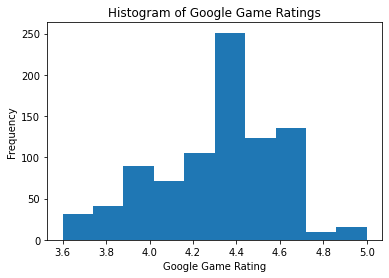

<Figure size 432x288 with 0 Axes>

In [108]:
# Plot histogram of google game rating
plt.hist(df2['google rating'])
plt.title("Histogram of Google Game Ratings")
plt.xlabel("Google Game Rating")
plt.ylabel("Frequency")
plt.show()
plt.savefig("Histogram_Ratings.pdf")

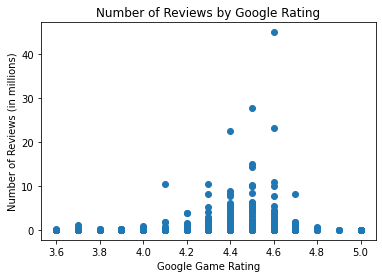

<Figure size 432x288 with 0 Axes>

In [113]:
# Scatterplot of the number of reviews on games by the game rating
plt.scatter(df2['google rating'], df2['google num reviews'] / 1000000)
plt.title("Number of Reviews by Google Rating")
plt.xlabel("Google Game Rating")
plt.ylabel("Number of Reviews (in millions)")
plt.show()
plt.savefig("Scatterplot Reviews by Ratings.pdf")

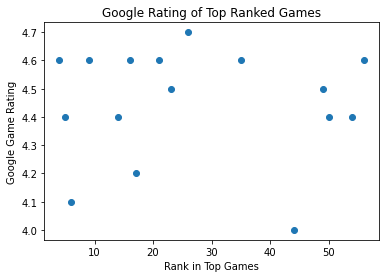

<Figure size 432x288 with 0 Axes>

In [110]:
# Use data from the combined df to make a scatter plot of the google rating of the 15 games that overlap with 
# the top game listing
plt.scatter(final_df['top ranking'], final_df['google rating'])
plt.title("Google Rating of Top Ranked Games")
plt.xlabel("Rank in Top Games")
plt.ylabel("Google Game Rating")
plt.show()
plt.savefig("Scatterplot Ratings by Rank.pdf")

In [86]:
# I want to look at the worldwide revenue by the number of google installs, so I'm going to divide installs by millions
# and revenue by billions to create new variables that will look better in the plot
inner_df['revenue_in_billions'] = inner_df['worldwide revenue'] / 1000000000
inner_df['installs_in_millions'] = inner_df['google num installs'] / 1000000

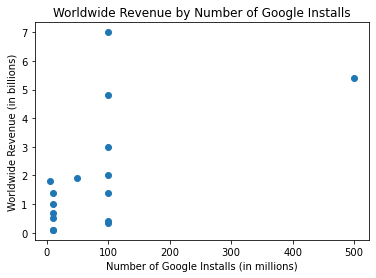

<Figure size 432x288 with 0 Axes>

In [111]:
plt.scatter(inner_df['installs_in_millions'], inner_df['revenue_in_billions'])
plt.title("Worldwide Revenue by Number of Google Installs")
plt.xlabel("Number of Google Installs (in millions)")
plt.ylabel("Worldwide Revenue (in billions)")
plt.show()
plt.savefig("Scatterplot Revenue by Installs.pdf")

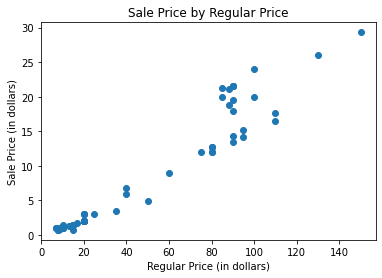

<Figure size 432x288 with 0 Axes>

In [112]:
plt.scatter(df3['reg price'], df3['sale price'])
plt.title("Sale Price by Regular Price")
plt.xlabel("Regular Price (in dollars)")
plt.ylabel("Sale Price (in dollars)")
plt.show()
plt.savefig("Scatterplot Sale Price by Regular Price.pdf")